<a href="https://colab.research.google.com/github/jdberkson/OPTI-556-Computational-Imaging/blob/main/Homework5_JoelB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5 OPTI 556

## Joel Berkson 11/14/2021

So we are given the following *coherent* impulse response of some system. We know that the incoherent response is the magnitude squared of this function:

$$
h_{incoherent}(x,y,z) = |h(x,y,z)|^2=|\frac{1}{w_o^2+i\lambda z}e^{2\phi i\frac{z}{\lambda}}e^{-\pi\frac{x^2+y^2}{w_o^2+i\lambda z}}|^2
$$

When I think of the resolution of an optical system, I always think of MTF. When I think of ways to test MTF, I always think of the knife edge test. This is done by creating a step function edge image. The derivative of a step function is a delta function, so propagating a knife edge through the system produces an edge spread function (ESF) and the derivative creates a line spread function (LSF). Doing this in X and Y and multiplexing gives a measured PSF. 

$$
LSF = \frac{\delta}{\delta x} (ESF(x))
$$

The system is rotationally symmetric anyway, so I will do most of the hw in 1D spatially. I decided for this hw to look at 3 MTF plots for each method.
1. MTF of blurred imaged
2. MTF of noisy blurred images (with the 3 different photons noises)
3. MTF of the corrected ESF


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d, convolve, wiener
from skimage import color, data, restoration, exposure
from skimage import io
from google.colab import files
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size': 16})

Incoherent transfer function

In [2]:
def g(rho,z, wo):
  # all spatial terms are in units of wavelengths
  g=(1/(wo**2+1j*z))*np.exp(2*np.pi*1j*z)*np.exp(-np.pi*rho**2/(wo**2+1j*z))
  return np.abs(g)**2

8.853127467300747e-09


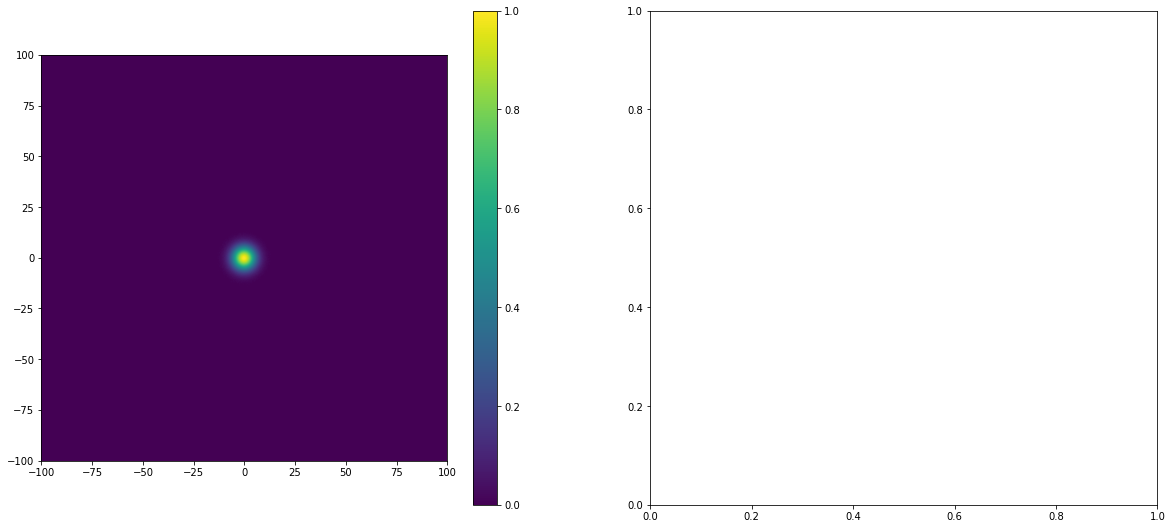

In [3]:
photons = 10000
x=np.linspace(-100,100,1024)
xx,yy= np.meshgrid(x,x)
X = np.abs(g(np.sqrt(xx**2+yy**2), 100, 5))**2
Xnorm = X/np.max(X)
print(np.max(X))
Xphotnoise = np.sqrt(np.random.poisson(np.power(Xnorm*np.sqrt(photons),2)))/np.sqrt(photons)
Xphotnoise[Xphotnoise>1] = 1
Xphotnoise[Xphotnoise<0] *= 0
plt.figure(figsize=[20,20])
plt.subplot(2,2,1)
plt.imshow(Xphotnoise,extent=[-100,100,-100,100])
plt.colorbar()
plt.subplot(2,2,2)


In [4]:
def edge(X):
  if X > 0:
      f = 1
  else:
      f = -1
  return f

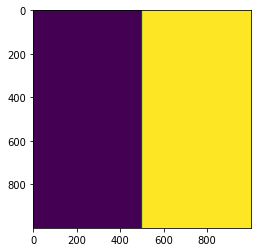

In [5]:
X = np.linspace(-100,100,1000)
X,Y= np.meshgrid(X,X)
rho = np.sqrt(X**2+Y**2)

edgefun = np.vectorize(edge)
KnifeEdge = edgefun(X)
plt.imshow(KnifeEdge)

We know that to calculate the image of a system, simply convolve the impulse response with the object, and this image is the Edge Spread Function

$$
I'(x,y,z) = h_{incoh}(x,y,z)**I(x,y,z)
$$

In [6]:

xx = np.linspace(-20,20,200)
xx,yy= np.meshgrid(xx,xx)
rho_trans = np.sqrt(xx**2+yy**2)
Zdist = np.linspace(0,20,11)
print(Zdist)
n = len(Zdist)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]


Creating Point Spread Function at each z distance

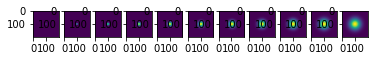

In [7]:
PSF = np.zeros([200,200,n])
for i in range(n):
  PSF[:,:,i] = g(rho_trans,Zdist[i],1)
  plt.subplot(1,n,i+1)
  
  plt.imshow(PSF[:,:,i])

Convoling Edge object with PSF to get image

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]
0
1
2
3
4
5
6
7
8
9
10


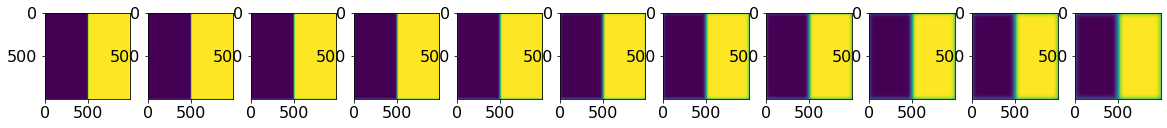

In [7]:

Image = np.zeros([1000,1000,n])
for i in range(n):
  PSF = g(rho_trans,Zdist[i],1)
  Image[:,:,i] = convolve2d(KnifeEdge,PSF,mode='same',boundary='fill')
  plt.subplot(1,n,i+1)
  plt.imshow(Image[:,:,i])


Saving because colvolution takes forever

In [11]:
file = open("Edges", "wb")
np.save(file,Image)
file.close()
files.download('Edges')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
files.upload()
file = open("Edges", "rb")
Image = np.load(file)
file.close()

Saving Edges to Edges (1)


Plot ESF,PSF (ignoring edge effects), and MTF (top to bottom)

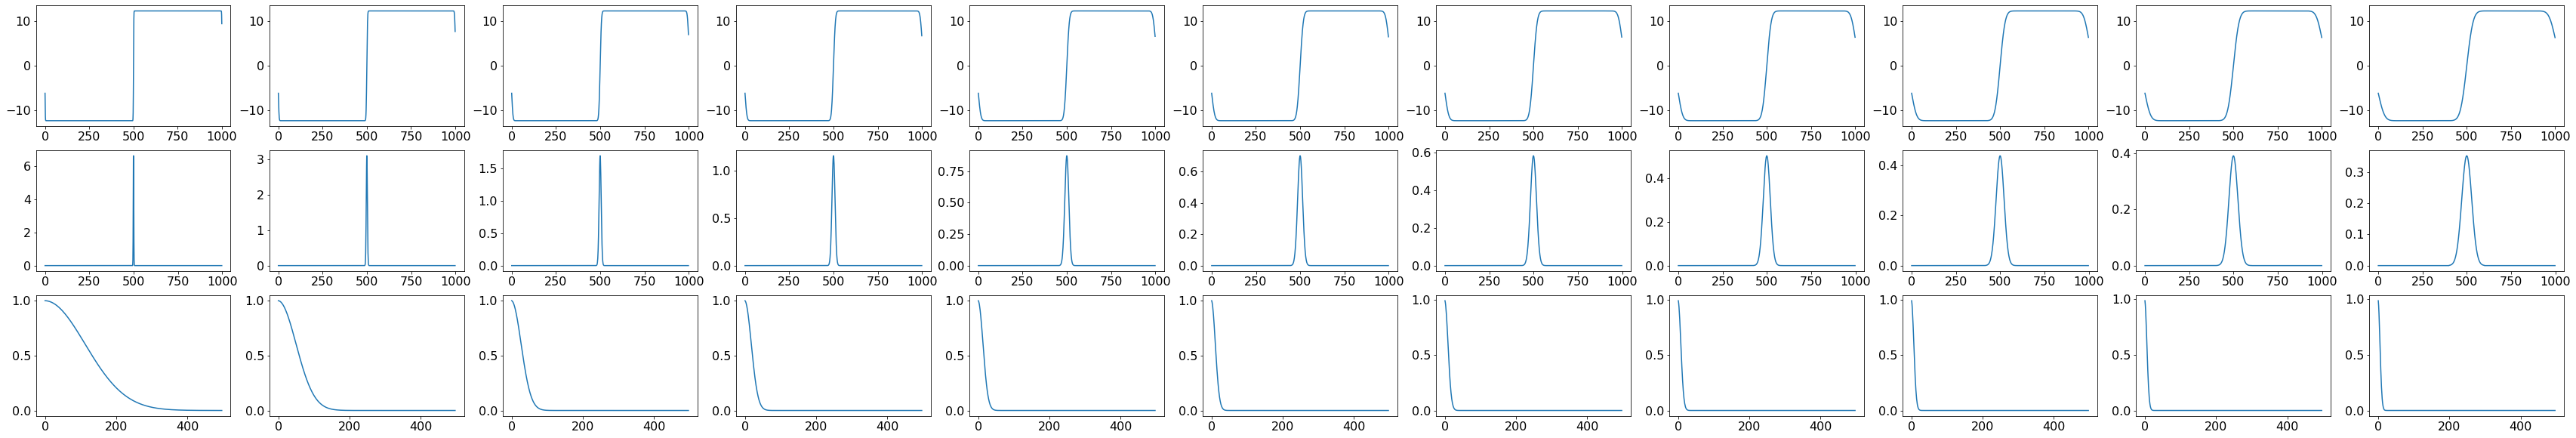

In [9]:
plt.rcParams['figure.figsize'] = [60, 10]
plt.rcParams.update({'font.size': 16})
LSF = np.zeros([1000,999,n])
MTFDefocus = np.zeros([500,n])
for i in range(n):
  LSF[:,:,i] = np.diff(Image[:,:,i])
  LSF[LSF<0] = 0
  MTF = np.abs(np.fft.fftshift(np.fft.fft(LSF[500,:,i])))
  
  MTFDefocus[:,i] = MTF[499:]/np.max(MTF[499:])
  #Edge Spread Function
  plt.subplot(3,n,i+1)
  plt.plot(Image[500,:,i])
  #Line Spread Function
  plt.subplot(3,n,i+1+n)
  plt.plot(LSF[500,:,i])
  #Modulation Transfer Function
  plt.subplot(3,n,i+1+2*n)
  plt.plot(MTF[500:-1]/np.max(MTF[499:]))

Then, stacking them all gives a Defocus MTF!

(500, 11)


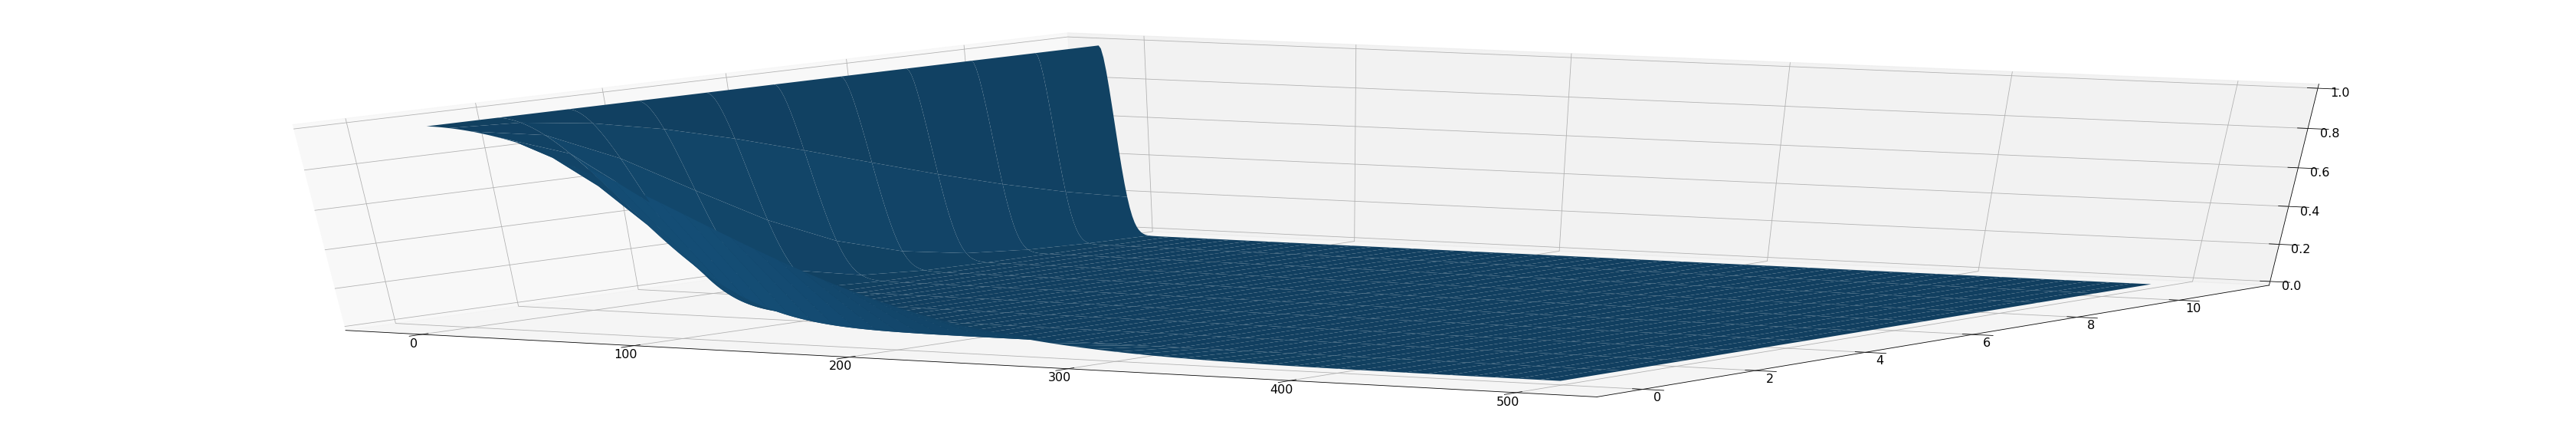

In [10]:
ax = plt.axes(projection ='3d')
x = np.linspace(0,499,500)
N = np.linspace(0,n,n)
nn,xx = np.meshgrid(N,x)
print(np.shape(MTFDefocus))
surf = ax.plot_surface(xx,nn,MTFDefocus)


I think in this case, the spatial freqeuncy is in $cycles/(1/λ)$

In [19]:
def calcMTF(ESF):
  LSF = np.diff(ESF)
  LSF[LSF<0] = 0
  MTF = np.abs(np.fft.fftshift(np.fft.fft(LSF)))
  MTF = MTF[499:]/np.max(MTF)
  return MTF

Now that I have all the ideal data, now to try improvement methods with different amounts of noise.

First, Wiener filtering

##Wiener Filtering

/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.7/dist-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/usr/local/lib/python3.7/dist-packages/scipy/signal/signal

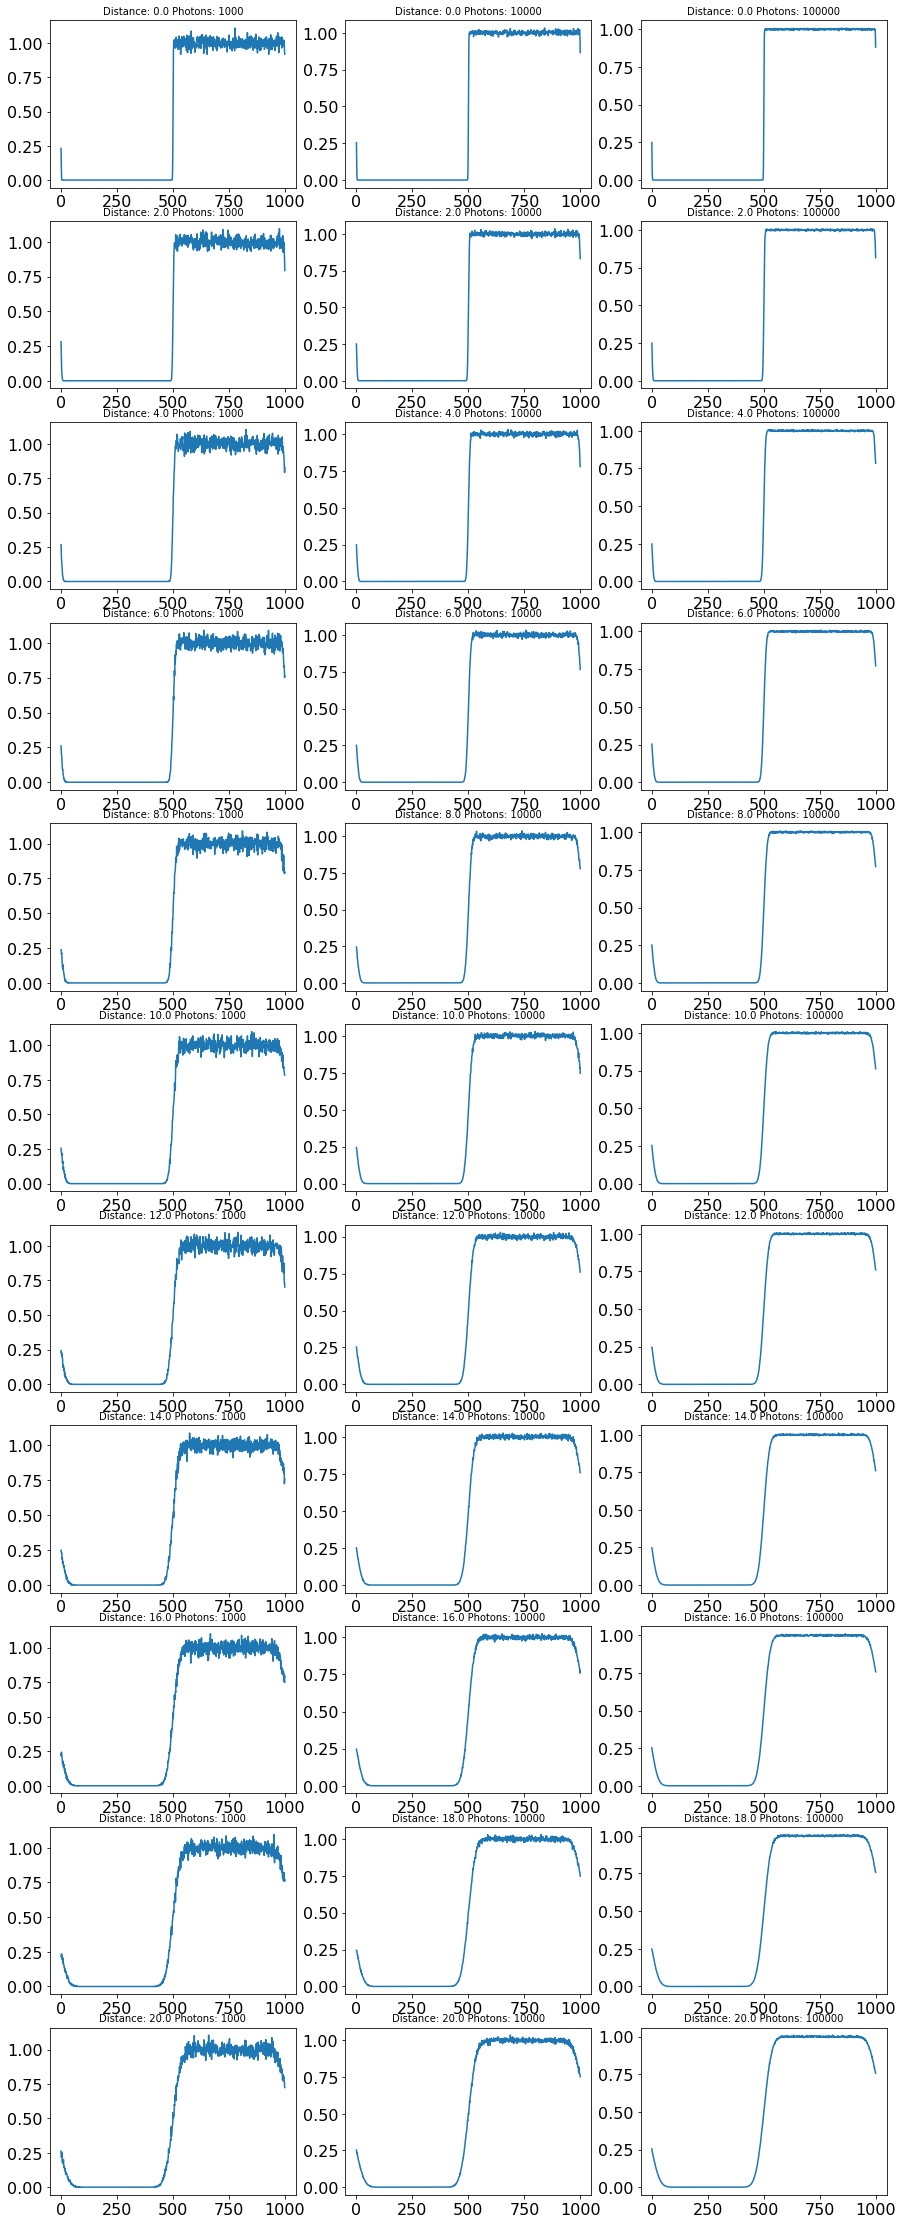

In [20]:
# convolve with sampling psf
snr=.01

photons = [1000,10000,100000]
deconvolved = np.zeros([1000,1000,n,len(photons)])
MTF_noise = np.zeros([500,n,len(photons)])
plt.rcParams['figure.figsize'] = [15, 40]
plt.rcParams.update({'font.size': 16})
for i in range(n):
  
  for j in range(len(photons)):
    Xshift = Image[:,:,i]-np.min(Image[:,:,i])
    Xnorm = Xshift/np.max(Xshift)
    Xphotnoise = np.random.poisson(photons[j]*Xnorm)/photons[j]

    MTF_noise[:,i,j] = calcMTF(Xphotnoise[500,:])


    deconvolved[:,:,i,j] = wiener(Xphotnoise,10)
    plt.subplot(n,len(photons),j+i*len(photons)+1)
    plt.title('Distance: '+str(Zdist[i])+' Photons: '+str(photons[j]),fontdict={'fontsize': 10})
    plt.plot(Xphotnoise[500,:])


Below, it looks like the wiener filtering i did helped the MTF recover some sections of higher freqeuncy information! But doesn't have a super extreme response

Blue is with noise, no correction, orange is with wiener filtering, and green is the original MTF with no noise. Clearly wiener filtering gelps quite a bit, but it doesn't get it back to the version without noise, and doesn't help as much at large amounts of defocus.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curre

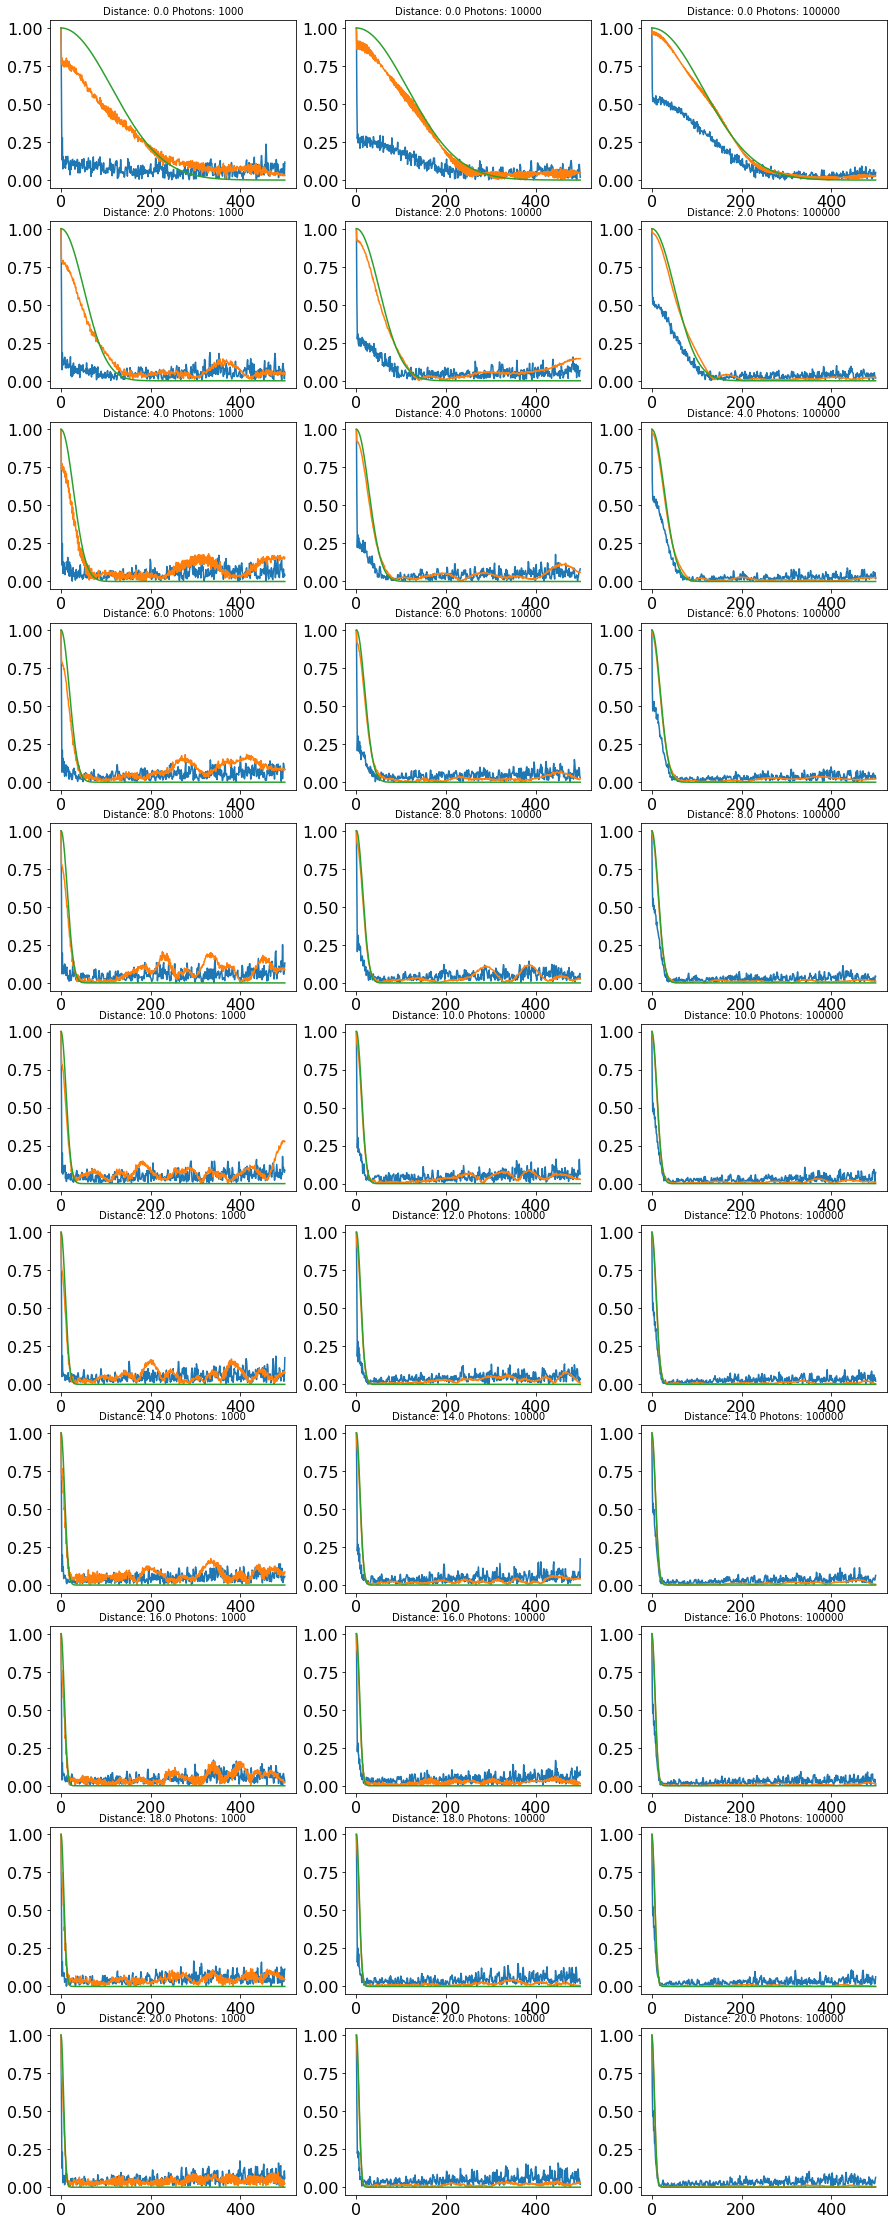

In [21]:
for i in range(n):
  for j in range(len(photons)):
    plt.subplot(n,len(photons),j+i*len(photons)+1)
    plt.title('Distance: '+str(Zdist[i])+' Photons: '+str(photons[j]),fontdict={'fontsize': 10})
   
    MTF_wiener = calcMTF(deconvolved[500,:,i,j])
    plt.plot(MTF_noise[:,i,j])
    plt.subplot(n,len(photons),j+i*len(photons)+1)
    plt.plot(MTF_wiener)
    plt.subplot(n,len(photons),j+i*len(photons)+1)
    plt.plot(MTFDefocus[:,i])
    plt.draw()
    
   


##Total Variation Deconvolution

In [28]:
# convolve with sampling psf


photons = [1000,10000,100000]
deconvolved = np.zeros([1000,1000,n,len(photons)])
MTF_noise = np.zeros([500,n,len(photons)])
plt.rcParams['figure.figsize'] = [15, 40]
plt.rcParams.update({'font.size': 16})
for i in range(n):
  
  for j in range(len(photons)):
    Xshift = Image[:,:,i]-np.min(Image[:,:,i])
    Xnorm = Xshift/np.max(Xshift)
    Xphotnoise = np.random.poisson(photons[j]*Xnorm)/photons[j]

    MTF_noise[:,i,j] = calcMTF(Xphotnoise[500,:])


    deconvolved[:,:,i,j] = restoration.denoise_tv_chambolle(Xphotnoise,.5)



MTF is much improved here by TV. Even for some of the infocus positions, TV recovers some more contrast at high spatial freqeuncies than the original without noise!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curre

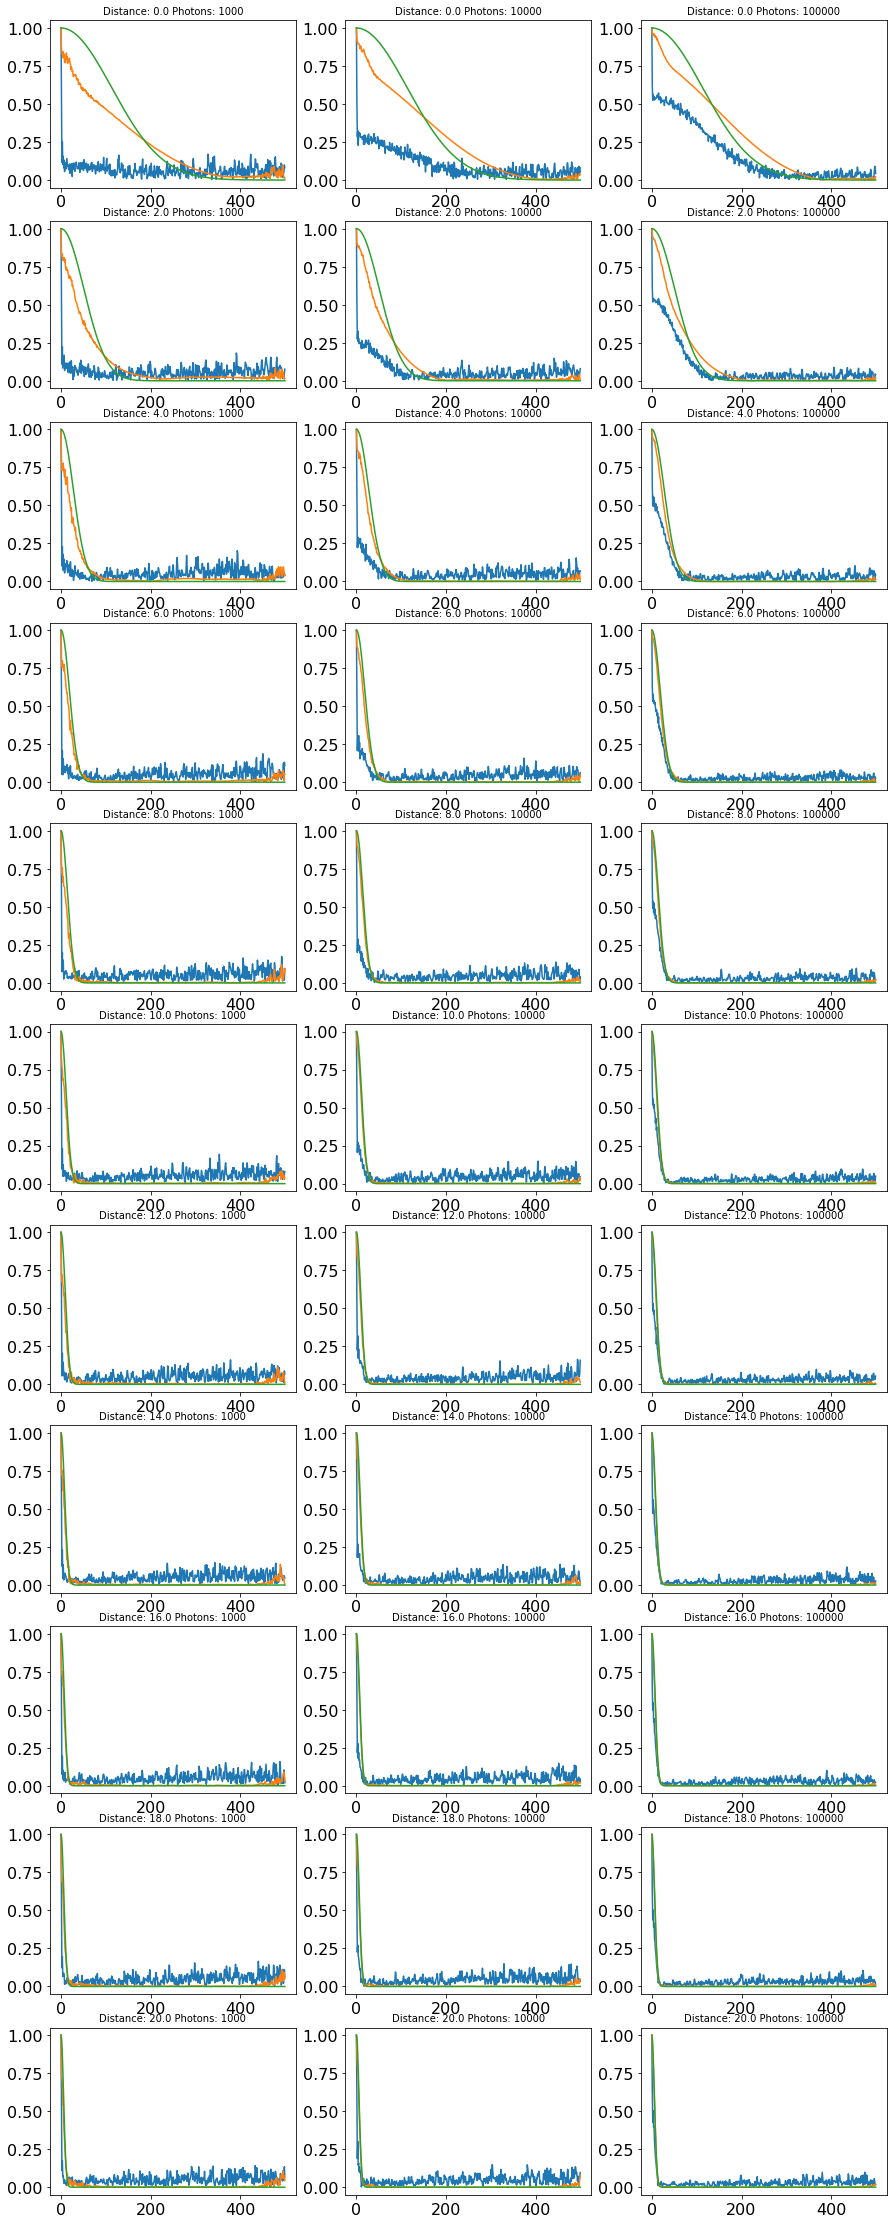

In [29]:
for i in range(n):
  for j in range(len(photons)):
    plt.subplot(n,len(photons),j+i*len(photons)+1)
    plt.title('Distance: '+str(Zdist[i])+' Photons: '+str(photons[j]),fontdict={'fontsize': 10})
   
    MTF_TV = calcMTF(deconvolved[500,:,i,j])
    plt.plot(MTF_noise[:,i,j])
    plt.subplot(n,len(photons),j+i*len(photons)+1)
    plt.plot(MTF_TV)
    plt.subplot(n,len(photons),j+i*len(photons)+1)
    plt.plot(MTFDefocus[:,i])
    plt.draw()

##Richardson-Lucy Deconvolution

/usr/local/lib/python3.7/dist-packages/skimage/restoration/deconvolution.py:376: RuntimeWarning: invalid value encountered in true_divide
  relative_blur = np.where(conv < filter_epsilon, 0, image / conv)
/usr/local/lib/python3.7/dist-packages/skimage/restoration/deconvolution.py:376: RuntimeWarning: invalid value encountered in true_divide
  relative_blur = np.where(conv < filter_epsilon, 0, image / conv)
/usr/local/lib/python3.7/dist-packages/skimage/restoration/deconvolution.py:376: RuntimeWarning: invalid value encountered in true_divide
  relative_blur = np.where(conv < filter_epsilon, 0, image / conv)
/usr/local/lib/python3.7/dist-packages/skimage/restoration/deconvolution.py:376: RuntimeWarning: invalid value encountered in true_divide
  relative_blur = np.where(conv < filter_epsilon, 0, image / conv)
/usr/local/lib/python3.7/dist-packages/skimage/restoration/deconvolution.py:376: RuntimeWarning: invalid value encountered in true_divide
  relative_blur = np.where(conv < filter_e

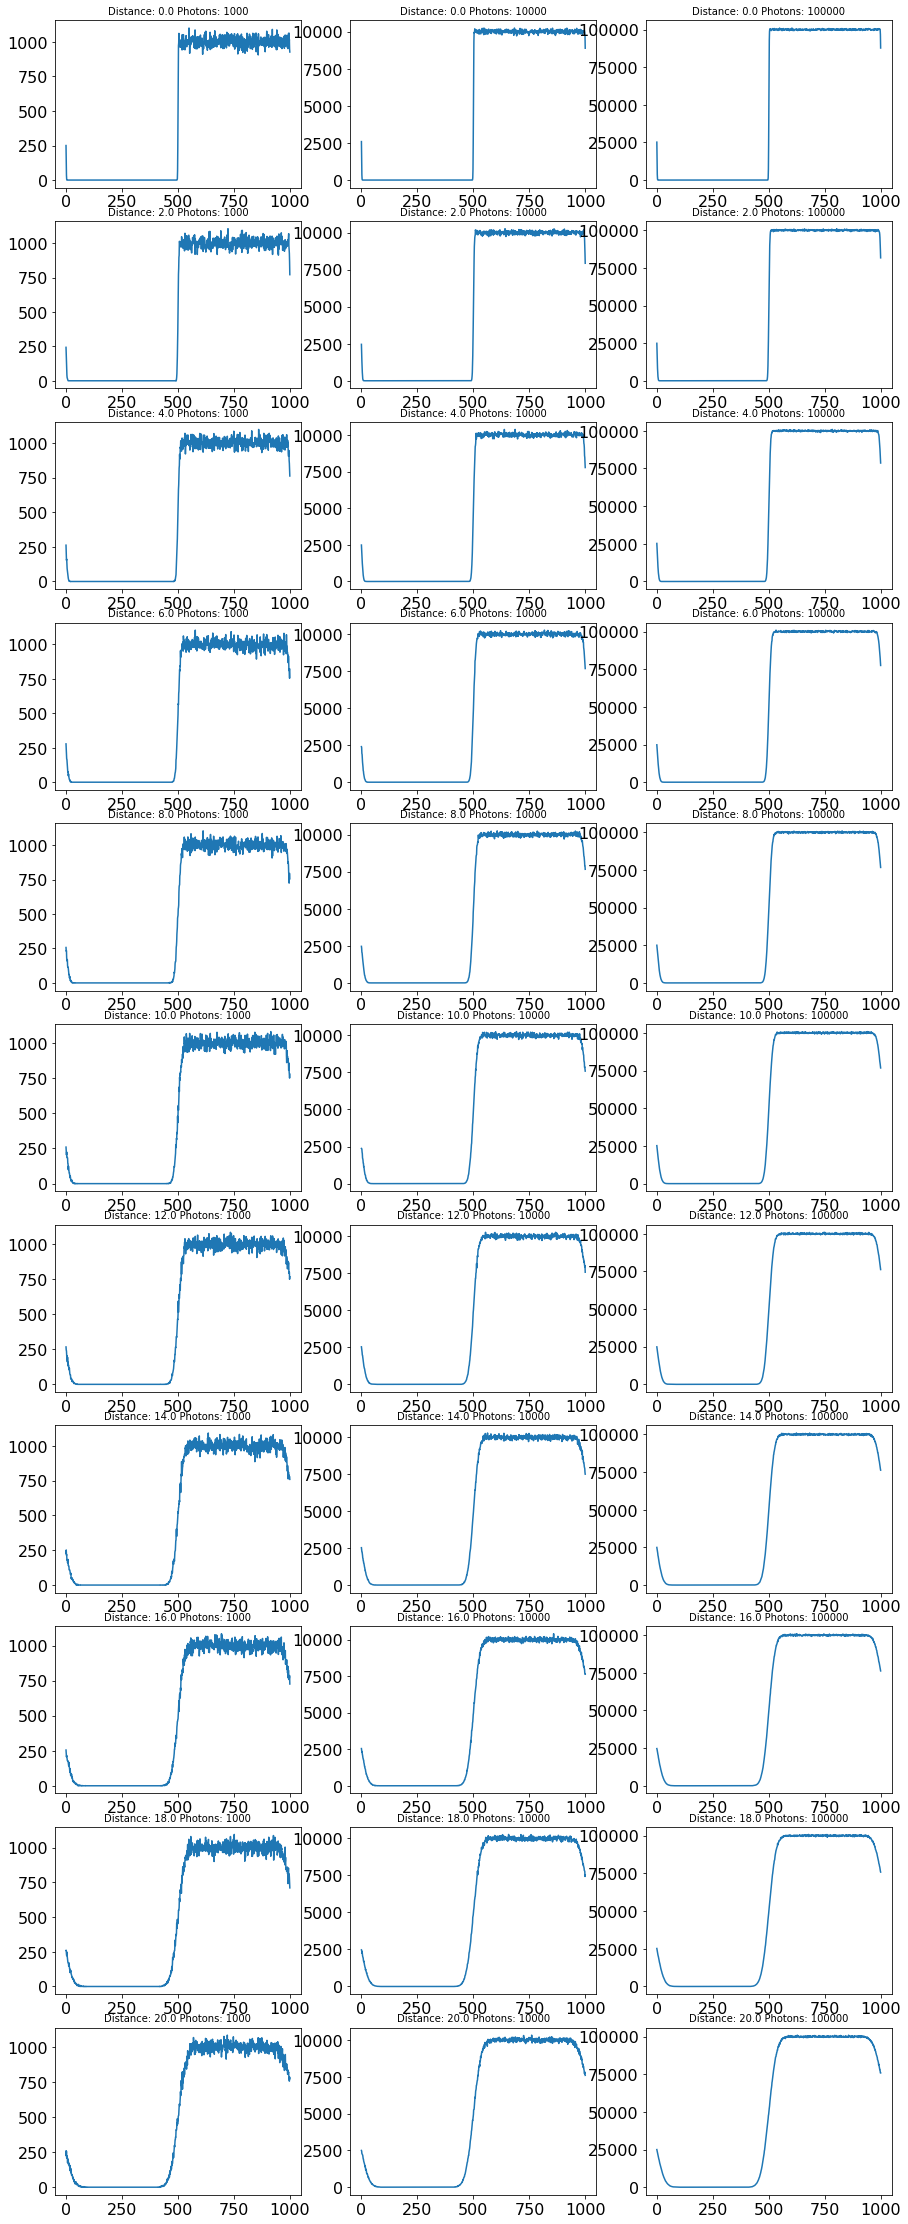

In [55]:
# convolve with sampling psf


photons = [1000,10000,100000]
deconvolved = np.zeros([1000,n,len(photons)])
MTF_noise = np.zeros([500,n,len(photons)])
plt.rcParams['figure.figsize'] = [15, 40]
plt.rcParams.update({'font.size': 16})
for i in range(n):
  
  for j in range(len(photons)):
    Xshift = Image[:,:,i]-np.min(Image[:,:,i])
    Xnorm = Xshift/np.max(Xshift)
    Xphotnoise = np.random.poisson(photons[j]*Xnorm)

    MTF_noise[:,i,j] = calcMTF(Xphotnoise[500,:])


    deconvolved[:,i,j] = restoration.richardson_lucy(Xphotnoise[500,:],PSF[100,:,i],iterations=50,filter_epsilon=.01)
    plt.subplot(n,len(photons),j+i*len(photons)+1)
    plt.title('Distance: '+str(Zdist[i])+' Photons: '+str(photons[j]),fontdict={'fontsize': 10})
    plt.plot(Xphotnoise[500,:])


WOW. This is by far the best performing method so far. Recovered MTF is much higher than the diffraction limit, especially for 10000 photons or greater. 1000 photons are a bit too noisy to be completely fixed, but over all still shows a huge improvement

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curre

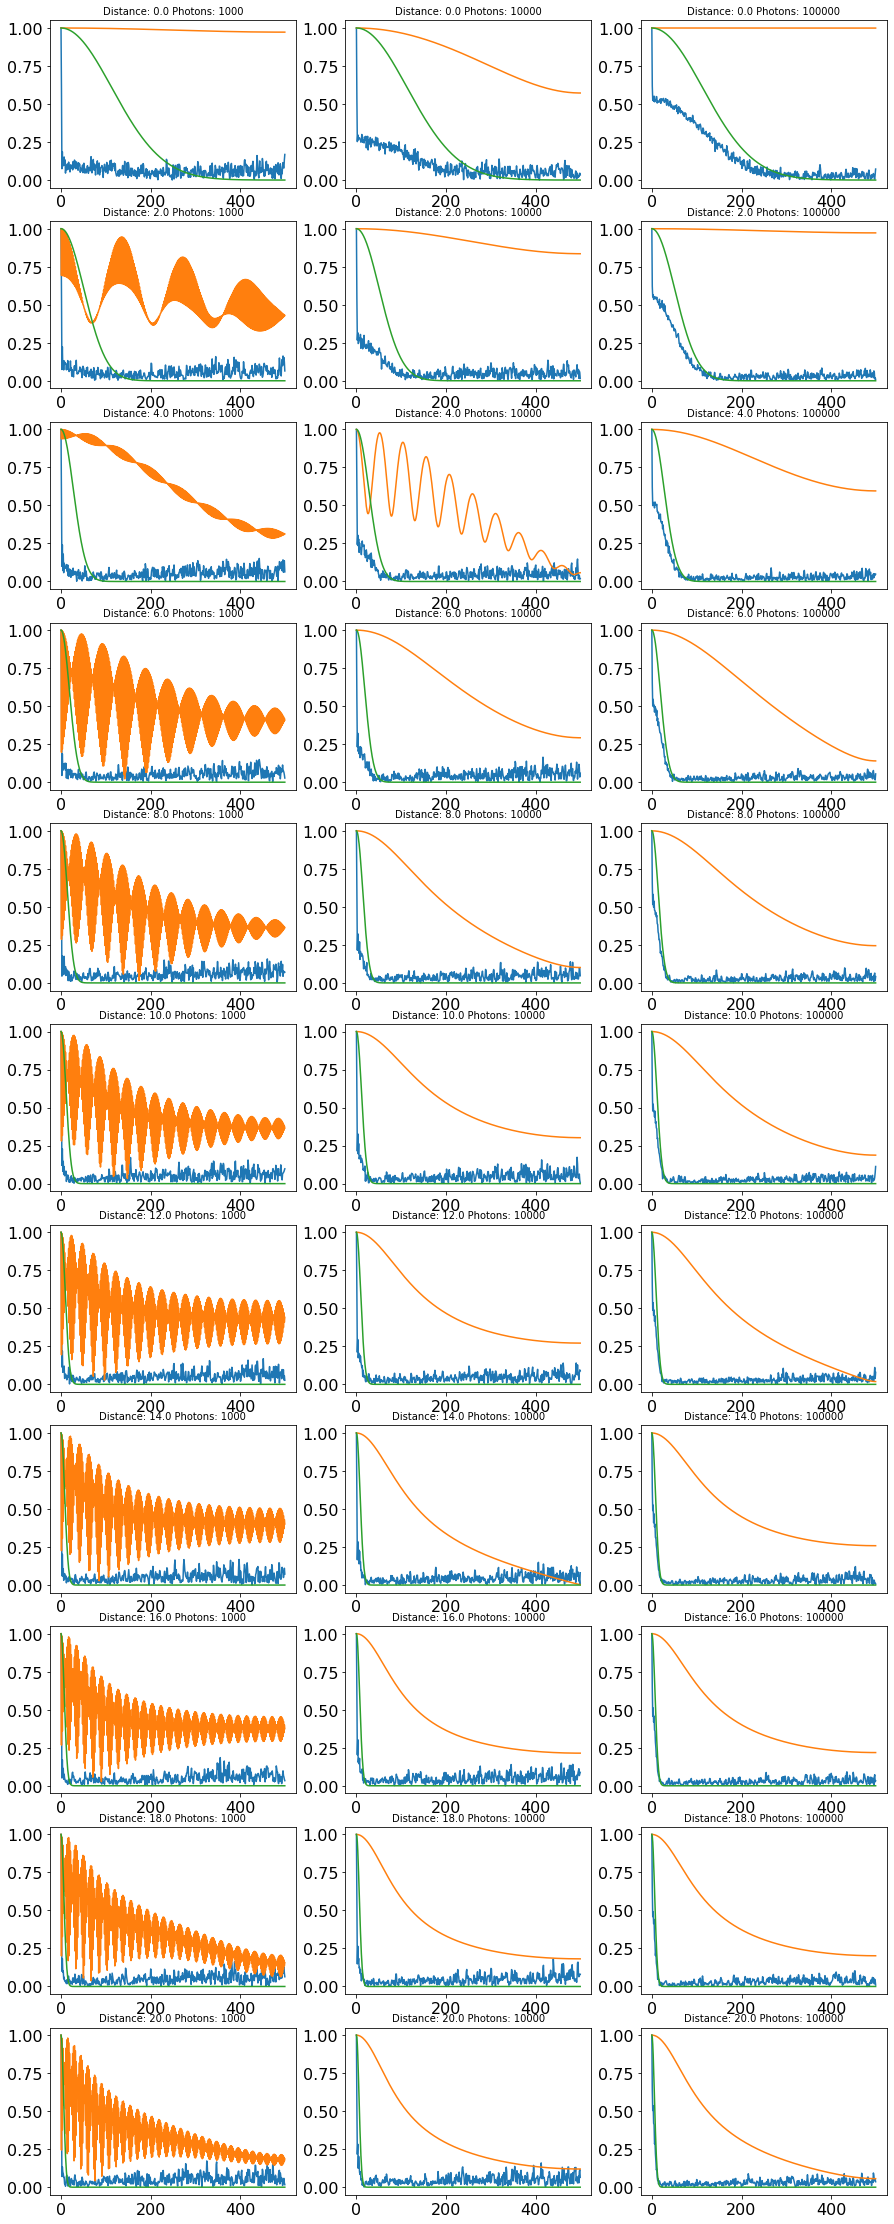

In [53]:
for i in range(n):
  for j in range(len(photons)):
    plt.subplot(n,len(photons),j+i*len(photons)+1)
    plt.title('Distance: '+str(Zdist[i])+' Photons: '+str(photons[j]),fontdict={'fontsize': 10})
   
    MTF_RL = calcMTF(deconvolved[:,i,j])
    plt.plot(MTF_noise[:,i,j])
    plt.subplot(n,len(photons),j+i*len(photons)+1)
    plt.plot(MTF_RL)
    plt.subplot(n,len(photons),j+i*len(photons)+1)
    plt.plot(MTFDefocus[:,i])
    plt.draw()

##Neural Network

Ran out of time to train/test a neural network. What I would do is scale up the mnist number images to 1000x1000, and use them to train neural deconvolutation and denoising, then try to apply it to the noisy edge spread fuction and look at the MTF.